<a href="https://colab.research.google.com/github/nhornos/CovidApp/blob/test/Cuaderno_1_martes_grupo9_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 - Introducción:
La funcionalidad que nos tocó fue la de aplicar el algoritmo "Brightening filter" a una imagen. Para ello, lo que implementamos es aumentar la intensidad de cada uno de los tres colores de cada pixel, multiplicándolos por un factor (configurable como variable al inicio del código). Ese factor debe ser mayor a 1. Cuanto más alto sea el factor, mayor será el abrillantamiento de la imagen.

**Fórmula aplicada:
G(x,y) = f(x,y) * b; b>1**

Procedemos a implementar el algoritmo ejecutando en CPU, y luego en GPU con CUDA. Se compararán los tiempos de ejecución en cada caso.


# 2 - Armado del ambiente

In [1]:
#@title ## 2.1 Parámetros de ejecución
#@markdown ---
#@markdown ### Especifique la URL de la imagen:
url_imagen = "https://raw.githubusercontent.com/nhornos/CovidApp/prod/HPC/ImagenUnlam.jpg" #@param {type:"string"}
#@markdown ---
# Leo la imagen desde internet.
#!wget https://github.com/wvaliente/SOA_HPC/blob/main/unlam.jpg?raw=true -O imagen.jpg

!wget {url_imagen} -O imagen.jpg


--2021-07-04 20:56:46--  https://raw.githubusercontent.com/nhornos/CovidApp/prod/HPC/ImagenUnlam.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 131903 (129K) [image/jpeg]
Saving to: ‘imagen.jpg’

imagen.jpg          100%[===================>] 128.81K  --.-KB/s    in 0.01s   

2021-07-04 20:56:46 (10.1 MB/s) - ‘imagen.jpg’ saved [131903/131903]



In [4]:
#@title ## 2.2 Instalación de la biblioteca pycuda
#@markdown ##### Esta biblioteca debe ser instalada previamente para poder ejecutar el algoritmo en GPU
!pip install pycuda

     |████████████████████████████████| 1.7MB 8.6MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 81kB 9.9MB/s 
     |████████████████████████████████| 71kB 9.9MB/s 
  Created wheel for pycuda: filename=pycuda-2021.1-cp37-cp37m-linux_x86_64.whl size=627583 sha256=b3ee897a61b321a38a9a29d427b41a8d1aea15203974915507a9c1dc375f873b
  Stored in directory: /root/.cache/pip/wheels/d5/55/64/fd4dddcc5f1c25eebd90b5291c3769101dc978c70165685512
Successfully built pycuda
  Created wheel for pytools: filename=pytools-2021.2.7-py2.py3-none-any.whl size=60644 sha256=d4543cf0704af894182d3ed18952f7b32292592983083978cc91f9fef5c06401
  Stored in directory: /root/.cache/pip/wheels/a0/b5/e5/e65d25997fd77729b9aa214645add18688483e48bbcbab6ffc
Successfully built pytools


#3 - Desarrollo CPU

Imagen del filtro: imagen.jpg -RGB- [1024, 768]
Tiempo de conversión de imagen: 8434.846 [ms]
Tiempo Total: 8565.864 [ms]


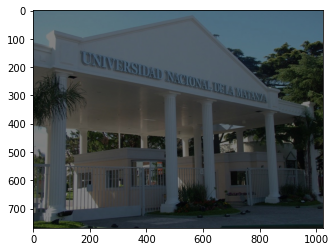

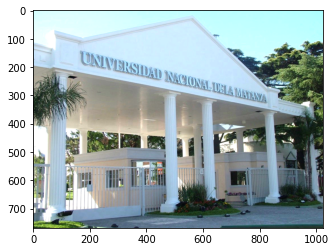

In [2]:
%matplotlib inline
from datetime import datetime

tiempo_total = datetime.now()

import matplotlib.pyplot as plt
import numpy
from PIL import Image 
import sys;

# --------------------------------------------
# Definición de función que transforma el tiempo en  milisegundos 
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0
# --------------------------------------------

#-------------------------------------------
# Definición función que aplica la transformación a cada color de un pixel
def aumentaBrillo(numero, escalar):
    valor = numero * escalar
    if valor > 255:
      valor = 255
    return valor
#-------------------------------------------

#Variables generales:
escalarBrillo = 2.5

#Manejo excepción archivo
try:
  img_nombre = 'imagen.jpg'
  image = Image.open( img_nombre ) 
except FileNotFoundError:
  sys.exit("Error. No existe la imagen " + img_nombre + " en el ambiente.")
# Obtengo las proporciones de la imagen. 
img_ancho, img_alto = image.size 

# Convierto la imagen comprimida en JPEG/PNG a array.
img_pic_cpu = numpy.asarray(image)
img_pic_cpu = img_pic_cpu.astype( numpy.int32() )

# Genero el array resultado.
img_picR_cpu = numpy.empty_like( img_pic_cpu)

# Muestro los atributos de la imagen y como se ve antes del seudo filtro.
print("Imagen del filtro: " + img_nombre + " -" + image.mode + "- [" + str(img_ancho) + ", " + str(img_alto ) + "]" )  

plt.figure()
imgplot=plt.imshow( img_pic_cpu )

tiempo_img = datetime.now()

# Convierto la imagen a escala de grises
for y  in range( 0, img_alto ):
  for x in range( 0, img_ancho ):
    pixel_R, pixel_G, pixel_B = img_pic_cpu[y][x]
    rojo = aumentaBrillo(pixel_R, escalarBrillo)
    verde = aumentaBrillo(pixel_G, escalarBrillo)
    azul = aumentaBrillo(pixel_B, escalarBrillo)
    
    img_picR_cpu[y][x] = [rojo, verde, azul]

tiempo_img = datetime.now() - tiempo_img

# Muestro la imagen luego de aplicarle el filtro.
plt.figure()
imgplot = plt.imshow( img_picR_cpu )

tiempo_total = datetime.now() - tiempo_total

print( "Tiempo de conversión de imagen:", tiempo_en_ms( tiempo_img   ), "[ms]" )
print( "Tiempo Total:",                   tiempo_en_ms( tiempo_total ), "[ms]" )

# 4 - Desarrollo GPU

Imagen del filtro: imagen.jpg -RGB- [1024, 768]
Thread: [ 16 , 19  ], Bloque : [ 64 , 41 ]
Total de Thread: [ 1024 , 779  ]  =  797696
Tiempo de conversión de imagen:  0.205 [ms]
Tiempo Total:  75.314 [ms]


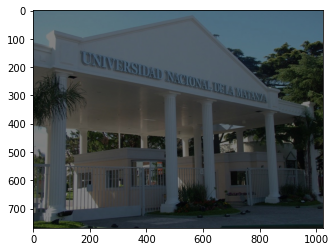

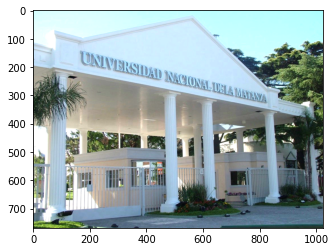

In [6]:
%matplotlib inline
from datetime import datetime
tiempo_total = datetime.now()

import matplotlib.pyplot as plt
import numpy
from PIL import Image 
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

# --------------------------------------------
# Definición de función que transforma el tiempo en  milisegundos 
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0
# --------------------------------------------

#Variables generales:
escalarBrillo = 2.5

#Manejo excepción archivo
try:
  img_nombre = 'imagen.jpg'
  image = Image.open( img_nombre ) 
except FileNotFoundError:
  sys.exit("Error. No existe la imagen " + img_nombre + " en el ambiente.")
  
# summarize some details about the image 
img_ancho, img_alto  = image.size 

# Convierto la imagen comprimida en JPEG/PNG a array
img_O_cpu = numpy.asarray(image)
img_O_cpu = img_O_cpu.astype( numpy.int32() )
img_R_cpu = numpy.empty_like( img_O_cpu)

# Reservo los 2 vectores en GPU(3 pixeles usa RGB * (el tamaño del array))
img_O_gpu = cuda.mem_alloc( img_O_cpu.nbytes )
img_R_gpu = cuda.mem_alloc( img_R_cpu.nbytes )

# GPU - Copio la memoria al GPU.
cuda.memcpy_htod( img_O_gpu, img_O_cpu )
cuda.memcpy_htod( img_R_gpu, img_R_cpu )

# CPU - Defino la función kernel que ejecutará en GPU.
module = SourceModule("""
__device__ float aumentaBrillo(float numero_color, float escalar_brillo){
  float valor = numero_color * escalar_brillo;
  if(valor > 255){
    valor = 255;
  }
  return valor;
}
__global__ void kernel_img( float escalar, int ancho, int alto, int *img_O, int *img_R )
{
  // Calculo las coordenadas del Thread en dos dimensiones.
  int idx = threadIdx.x + blockIdx.x*blockDim.x;
  int idy = threadIdx.y + blockIdx.y*blockDim.y;
  float fRojo;
  float fVerde;
  float fAzul;

  // Verifico que los Thread, esten dentro de las dimensiones de la imagen.
  if( idx < ancho && idy < alto )
  {
    // Aumento el brillo por el escalar definido
    fRojo = aumentaBrillo((float)img_O[(idx+(idy*ancho))*3], escalar); // Componente Rojo del pixel.
    fVerde = aumentaBrillo((float)img_O[((idx+(idy*ancho))*3)+1], escalar); // Componente Verde del pixel.
    fAzul = aumentaBrillo((float)img_O[((idx+(idy*ancho))*3)+2], escalar); // Componente Azul del pixel.
    // Escribo el color del pixel.
    img_R[(idx+(idy*ancho))*3  ] = (int) fRojo;
    img_R[(idx+(idy*ancho))*3+1] = (int) fVerde;
    img_R[(idx+(idy*ancho))*3+2] = (int) fAzul;
    //img_R[(idx+(idy*ancho))*3  ] = 255;
    //img_R[(idx+(idy*ancho))*3+1] = 255;
    //img_R[(idx+(idy*ancho))*3+2] = 255;
  }

}
""")

# Muestro los atributos de la imagen y como se ve antes del seudo filtro.
print("Imagen del filtro: " + img_nombre + " -" + image.mode + "- [" + str(img_ancho) + ", " + str(img_alto ) + "]" )  

# CPU - Genero la función kernel.
kernel = module.get_function("kernel_img")

tiempo_img = datetime.now()

dim_hilo_x = 16
dim_bloque_x = numpy.int( (img_ancho+dim_hilo_x-1) / dim_hilo_x )

dim_hilo_y = 19
dim_bloque_y = numpy.int( (img_alto+dim_hilo_y-1) / dim_hilo_y )

print( "Thread: [", dim_hilo_x, ",", dim_hilo_y, " ], Bloque : [", dim_bloque_x, ",", dim_bloque_y, "]" )
print( "Total de Thread: [", dim_hilo_x*dim_bloque_x, ",", dim_hilo_y*dim_bloque_y, " ]", " = ", dim_hilo_x*dim_bloque_x*dim_hilo_y*dim_bloque_y )

tiempo_img = datetime.now()

kernel(numpy.float32(escalarBrillo), numpy.int32(img_ancho), numpy.int32(img_alto), img_O_gpu, img_R_gpu, block=( dim_hilo_x, dim_hilo_y, 1 ), grid=(dim_bloque_x, dim_bloque_y,1) )

tiempo_img = datetime.now() - tiempo_img

# GPU - Copio el resultado desde la memoria GPU.
cuda.memcpy_dtoh( img_R_cpu, img_R_gpu )

# Muestro la imagen Original el filtro.
plt.figure()
imgplot=plt.imshow( img_O_cpu )

# Muestro la imagen luego de aplicarle el filtro.
plt.figure()
imgplot=plt.imshow( img_R_cpu )

tiempo_total = datetime.now() - tiempo_total

print("Tiempo de conversión de imagen: ", tiempo_en_ms( tiempo_img ), "[ms]" )
print("Tiempo Total: ", tiempo_en_ms( tiempo_total ), "[ms]" )


# 5 - Métricas

En esta sección detallaremos los datos de ejecución obtenidos en la ejecución con CPU y GPU.

## 5.1 - CPU
Inicialmente se ejecutó el código en CPU. Los valores de tiempo arrojados son los siguientes:

**Tiempo de conversión de imagen: 8434.846 [ms]**

**Tiempo Total: 8565.864 [ms]**

## 5.2 - GPU

Luego de la ejecución por CPU, se ejecutó el mismo código adaptado en GPU. Los valores de tiempo que arrojó la ejecución fueron los siguientes:

**Tiempo de conversión de imagen:  0.205 [ms]**

**Tiempo Total:  75.314 [ms]**

# 6 - Conclusiones
Analizando los valores de tiempo arrojados en las ejecuciones, a simple vista podemos detectar el impacto de la velocidad de ejecución mediante CUDA. El tiempo total que arrojó la ejecución por CPU es de **8346 milisegundos (8,3 segundos)**, mientras que el tiempo total de ejecución del algoritmo en GPU es de **76 milisegundos (menos de 0,1 segundo)**. 

En este primer caso, podemos ver que la diferencia en la velocidad de ejecución es extremadamente grande, dando como resultado una relación de 109,8 en 1. Eso significa que el tiempo total de ejecución es 110 veces más rapido en GPU que CPU.

Pero eso no es todo, además tenemos otro valor para analizar: el tiempo de conversión de imagen. El mismo en CPU arrojó un tiempo de **8205 milisegundos (8,2 segundos)**. Como se puede ver, casi la totalidad del tiempo de la ejecución del algoritmo en CPU corresponde a la conversión de la imagen. Sin embargo, el tiempo de conversión de la imagen en GPU fue de **0.143 milisegundos (menos de 0,00015 segundos)**. 

Como podemos visualizar en este segundo caso, en GPU el asunto es totalmente diferente. El tiempo de conversión de la imagen (el cual equivale al tiempo de ejecución de la GPU) es prácticamente nulo si lo comparamos con el tiempo total de ejecución del algoritmo. Como conclusión, el algoritmo de conversión de imagen es 57377 veces más rapido ejecutándolo mediante hilos en CUDA que ejecutándolo en CPU. El resto del tiempo de agregado de procesamiento en el algoritmo de GPU corresponde a la comunicación y traspaso de datos en memoria del GPU al CPU, y la liberación de la memoria correspondiente.

# 7 - Bibiliografía
https://www.sciencedirect.com/science/article/pii/S1877050916001976